In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import math
# %matplotlib inline

In [3]:
print('OpenCv Version:',cv2.__version__)

OpenCv Version: 3.4.2


In [4]:
def show(image):
    cv2.imshow("img", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #

In [5]:
transA = cv2.imread("data/transA.jpg", 0)
transB = cv2.imread("data/transB.jpg", 0)
simA = cv2.imread("data/simA.jpg", 0)
simB = cv2.imread("data/simB.jpg", 0)

In [6]:
show(transB)

In [7]:
def gradients_all(img):
    ret = {}
    
    img = cv2.GaussianBlur(img, (5,5), sigmaX = 2)
    
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = 5) #kernel_sum = 240
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = 5)
    
    com_img = np.hstack((Ix,Iy))
    imshow(com_img, cmap='gray');
    
    Ixx = Ix * Ix
    Ixy = Ix * Iy
    Iyy = Iy * Iy
    
    ret = {
        "img": img,
        "Ix" : Ix,
        "Iy" : Iy,
        "Ixx": Ixx,
        "Ixy": Ixy,
        "Iyy": Iyy,
          }
    
    return ret

array([[  0., 138., 242., ...,  28.,   6.,   0.],
       [  0., 130., 231., ...,  23.,   4.,   0.],
       [  0., 112., 202., ...,  10.,  -2.,   0.],
       ...,
       [  0., -27., -50., ...,  47.,  31.,   0.],
       [  0., -12., -26., ..., 102.,  59.,   0.],
       [  0.,  -8., -18., ..., 128.,  72.,   0.]])

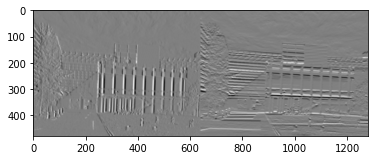

In [8]:
ret = gradients_all(transA)
ret["Ix"]

In [9]:
def non_max_suppression(res, offset = 1):
    
    h, w = res.shape
    
    for i in range(offset, h - offset):
        for j in range(offset, w - offset):
            b = res[i - offset: i + offset + 1, j - offset: j + offset + 1]
            m = b.max()
            b[b<m] = 0
    
    return res

In [122]:
def harris_response(parameters, k = 0.05, offset = 1):
    
    img = parameters["img"]
    Ix = parameters["Ix"]
    Iy = parameters["Iy"]
    Ixx = parameters["Ixx"]
    Ixy = parameters["Ixy"]
    Iyy = parameters["Iyy"]
    
#     detA = Ixx + Iyy - 2 * Ixy
    
#     traceA = Ixx + Iyy
    
#     response = detA - k * (traceA ** 2)
    
    h,w = parameters["img"].shape
    Sxx = np.zeros((h, w)) #(h - 2 * offset,w - 2 * offset)
    Sxy = np.zeros((h, w))
    Syy = np.zeros((h, w))
    
    for i in range(offset, h - offset):
        for j in range(offset, w - offset):
            Sxx[i, j] = np.sum(Ixx[i - offset: i + offset + 1, j - offset: j + offset + 1])
            Sxy[i, j] = np.sum(Ixy[i - offset: i + offset + 1, j - offset: j + offset + 1])
            Syy[i, j] = np.sum(Iyy[i - offset: i + offset + 1, j - offset: j + offset + 1])
    
#     mat = [
#              [Sxx, Sxy]
#              [Sxy, Syy]
#           ]
    
    
    det = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    
    res = det - k * (trace ** 2)
    img_corners = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    corners = []
    
    #thresholding
    max_response = res.max()
    res[res < max_response * 0.01] = 0
    
    #non-max-suppression
    res = non_max_suppression(res, offset=2)
    
    
    for i in range(offset,h-offset):
        for j in range(offset,w-offset):
            if res[i, j] > 0: # response > 0 === corner
                img_corners[i, j] = [0, 255, 0]
#                 points.append([i,j])
#                 kp = cv2.KeyPoint(j,i, _size = 1, _angle=np.degrees(math.atan2(Iy[i, j+1] - Iy[i,j-1],Ix[i+1, j] - Ix[i-1,j])))
                kp = cv2.KeyPoint(j,i, _size = 2, _angle=np.degrees(math.atan(-Iy[i, j] / Ix[i, j])))
#                 kp = cv2.KeyPoint(j,i, _size = 1, _angle=np.degrees(np.arctan2(Iy[i, j],Ix[i, j]))+180)
                corners.append(kp)  
    
    #storing data
    parameters["img_corners"] = img_corners
    parameters["corners"] = corners
    parameters["response"] = res
    
    return parameters
    
    
    

In [11]:
def sift(parameters):
    
    img = parameters["img"]
    corners = parameters["corners"]
    
    #SIFT
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    parameters["keypoints"] = keypoints
    parameters["descriptors"] = descriptors
    
    return parameters
    
    

In [12]:
def match(p1, p2):
    
    des1 = p1["descriptors"]
    des2 = p2["descriptors"]
    
    matcher = cv2.BFMatcher()
    matches = matcher.match(des1, des2)
    
    return matches    

In [13]:
def compute(img):
    
    p = gradients_all(img)
    p = harris_response(p)
    p = sift(p)
    
    return p

In [14]:
parameters = harris_response(ret)

In [15]:
parameters = sift(parameters)

In [16]:
show(parameters["img_corners"])
cv2.imwrite("data/transA_corners.png",img2)
# show(parameters["img"])

NameError: name 'img2' is not defined

In [ ]:
# parameters["img_corners"]

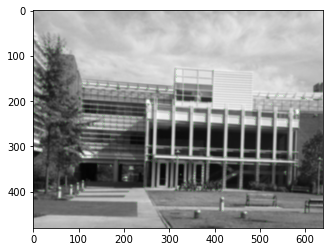

In [143]:
imshow(parameters["img_corners"]);
des_img = np.zeros((transA.shape[0],transA.shape[1],3), dtype=np.uint8)
img2 = cv2.drawKeypoints(parameters["img"],parameters["corners"], des_img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# img2 = cv2.drawKeypoints(transA,parameters["keypoints"],None,(255,0,0),10)
show(img2)

In [140]:
# sift = cv2.xfeatures2d.SIFT_create()
# kp = sift.detect(transA,None)
# img=cv2.drawKeypoints(transA,kp,transA)
img=cv2.drawKeypoints(resA["img"],resA["corners"],transA,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show(img)

In [19]:
(np.degrees(np.arctan2(parameters["Iy"],parameters["Ix"]))+180).max()

360.0

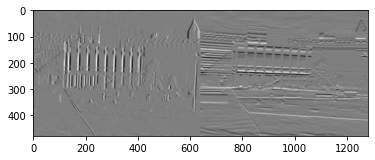

In [123]:
resA = compute(transA)
resB = compute(transB)

In [124]:
a = match(resA,resB)

In [125]:
matches = match(resA, resB)

In [126]:
type(similar_matches)

list

In [127]:
threshold = 0.5
i = 0
similar_matches_count = np.array([], dtype=np.uint32)
similar_matches = []
for j in range(len(matches)):
    dist = matches[j].distance
    k = 0
    cross_matches = np.array([])
    for i in matches:
        if i.distance <= dist + threshold and i.distance >= dist - threshold:
            k += 1
            cross_matches = np.append(cross_matches, i)
#     print(cross_matches)
    similar_matches_count = np.append(similar_matches_count, k)
    similar_matches.append(cross_matches)
#     print(similar_matches)

In [144]:
matches = sorted(matches, key = lambda x : x.distance)

In [128]:
max_pos = similar_matches_count.argmax()
similar_matches_count.max()

18

In [145]:
img3 = cv2.drawMatches(transA, resA["keypoints"], transB, resB["keypoints"], matches[:10], outImg = transA, flags=2)
show(img3)

In [106]:
len(resB["keypoints"])

1024

In [56]:
a = np.array([[]])
a[0]

array([], dtype=float64)

In [92]:
len(similar_matches[371])

101

In [50]:
a = np.array([])
a[0]
a = np.append(a,[2])
a

IndexError: index 0 is out of bounds for axis 0 with size 0

In [162]:
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(resA["descriptors"], resB["descriptors"], k=2)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
img3 = cv2.drawMatchesKnn(transA,resA["keypoints"], transB, resB["keypoints"],good,flags=2, outImg=des_img)

show(img3)#,plt.show()

351

In [114]:
matcher = cv2.BFMatcher()
matches1 = matcher.knnmatch(resA["descriptors"], resB["descriptors"], k=2)

AttributeError: 'cv2.BFMatcher' object has no attribute 'knnmatch'

In [112]:
img3 = cv2.drawMatchesKnn(transA,resA["keypoints"],transB,resB["keypoints"],matches1[0:50], flags=2, outImg = transA)

SystemError: <built-in function drawMatchesKnn> returned NULL without setting an error

In [144]:
show(img3)

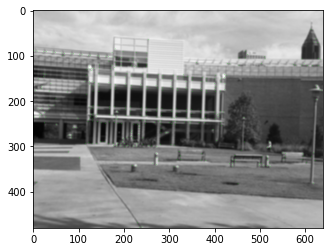

In [127]:
imshow(resB["img_corners"]);
des_img = np.zeros((transB.shape[0],transB.shape[1],3), dtype=np.uint8)
img2 = cv2.drawKeypoints(resB["img"],resB["keypoints"], des_img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# img2 = cv2.drawKeypoints(transA,parameters["keypoints"],None,(255,0,0),10)
show(img2)